Network construction:

  Some libraries

In [1]:
# Library needed for undersampling
!pip install -U imbalanced-learn

     |████████████████████████████████| 163kB 8.3MB/s 
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [2]:
!pip3 install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.2.0)


In [3]:
"""Imports: librerias"""
import os
import math
from math import sqrt
import sys
import numpy as np
import random
import scipy.stats
from pylab import *
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from time import time
import keras
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, add
from tensorflow.python.keras import Sequential, initializers, regularizers
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import confusion_matrix, hamming_loss, classification_report, roc_curve, auc, mean_squared_error, mean_absolute_error, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd  
import tensorflow as tf
from keras.utils import multi_gpu_model
##Para cambiar las fuentes
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 'large'
mpl.rcParams['ytick.labelsize'] = 'large'
mpl.rcParams['axes.labelsize'] = 'large'
#mpl.rcParams['xtick.labelsize'] = 'XX-large'
#mpl.rcParams['ytick.labelsize'] = 'XX-large'
#mpl.rcParams['axes.labelsize'] = 'XX-large'
mpl.rcParams['axes.titlesize'] = 'large'
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['font.size'] = '16'
np.set_printoptions(threshold=np.inf)

import pdb # Para depurar
import copy


Using TensorFlow backend.


We use an example data set, substitute for the desired dataset to be treated. The data set has to include a target variable a a weight variable.

In [0]:
d = {'mupt1': [61,38,28], 'mueta1': [0.34,1.35,-1.39],'muiso1': [0.4,0,0], 
     'mupt2': [0,0,0], 'mueta2': [0,0,0],'muiso2': [0,0,0],
		   'mupt3': [0,0,0], 'mueta3': [0,0,0],'muiso3': [0,0,0],
			  'jpt1': [0,46,0], 'jeta1': [0,1.27,0],'jbtag1': [0,-1,0],
				 'jpt2': [0,52,0], 'jeta2': [0,1.3,0],'jbtag2': [0,1.95,0],
				 'jpt3': [0,38,0], 'jeta3': [0,0.38,0],'jbtag3': [0,-1,0],
				 'jpt4': [0,0,0], 'jeta4': [0,0,0],'jbtag4': [0,0,0],
				 'jpt5': [0,0,0], 'jeta5': [0,0,0],'jbtag5': [0,0,0],
				 'jpt6': [0,0,0], 'jeta6': [0,0,0],'jbtag6': [0,0,0],'met':[23.98,15.66,37.72],
				 'weight':[2.4,2.33,2.53],'Label':[0,1,0],
				 'reliso1':[0,0.05,0.03],'reliso2':[-1,0.05,-1],'reliso3':[-1,-1,-1],
				 'nmuons':[1,2,1],'nisomuons':[1,2,1],'njets':[1,0,0],'nbtag':[0,0,0]}
example = pd.DataFrame(data=d)
frames = [example,example,example,example,example,example,example,example]
data = pd.concat(frames, ignore_index=True)
	

We select the training variables and the target.

In [39]:
v = np.concatenate((np.arange(29),np.arange(7)+30),axis=0) 
print(v)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 30 31 32 33 34 35 36]


In [40]:
Y= data.iloc[:,29]
X= data.iloc[:,v]
X.shape

# We create test an train data sets.
	
test_size = int(np.floor(0.30*X.shape[0]) )
trainX, testX = X[:-test_size], X[-test_size:]
trainY, testY = Y[:-test_size], Y[-test_size:]
trainX_num=trainX.shape[1]

print(trainX.shape, testX.shape,trainY.shape, testY.shape)
print("trainX.shape", trainX.shape[0], trainX.shape[1],trainX_num)
errors= np.empty([test_size])


(17, 36) (7, 36) (17,) (7,)
trainX.shape 17 36 36


We separate the weight and type variable from the rest of training variables.

In [41]:
v1 = np.concatenate((np.arange(28),np.arange(7)+29),axis=0) 
print(v1)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 29 30 31 32 33 34 35]


We first perform undersampling using the functions from the Imbalanced Library. The under samplig sets the data sorted so before we separate the train set from the test set we shuffle. After this we separate the weight variable.

In [42]:
## Undersampling
from imblearn.under_sampling import RandomUnderSampler
## Fraction of the background
(a1,b) = trainX[Y==1].shape
(a2,b) = trainX[Y==0].shape
alpha = 1/(a2/(a1/0.4))
rus = RandomUnderSampler(sampling_strategy=0.7,random_state=123456)
trainX_resampled, trainY_resampled = rus.fit_resample(trainX, trainY)
print('quantity of signal',(a1,b))
print('quantity of background',(a2,b))

## Shuffling data after undersampling
shuffled = pd.concat([trainX_resampled, trainY_resampled], axis=1)
shuffled = shuffled.sample(frac=1,random_state=123456)

print('final number of observations of the training set',shuffled.shape)

trainX_resampled = shuffled.iloc[:,0:36]
trainY_resampled = shuffled.iloc[:,36]

trainY_resampled

quantity of signal (6, 36)
quantity of background (11, 36)
final number of observations of the training set (14, 37)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


3     0
12    1
5     0
6     0
11    1
9     1
4     0
7     0
0     0
8     1
13    1
2     0
10    1
1     0
Name: Label, dtype: int64

In [43]:
# We separate the weight and type variable and reserve it for later use.

train_weights = trainX_resampled.iloc[:,28]

## Test set weights
testweights = testX.iloc[:,28]

trainX_resampled = trainX_resampled.iloc[:,v1]
testX = testX.iloc[:,v1]
print(trainX_resampled.shape, trainY_resampled.shape)

(14, 35) (14,)


17    2.53
18    2.40
19    2.33
20    2.53
21    2.40
22    2.33
23    2.53
Name: weight, dtype: float64

In [44]:
trainX = np.asarray(trainX_resampled)# Converting to Numpy Arrays
trainY = np.asarray(trainY_resampled)# to be able to use the keras functions
testX = np.asarray(testX)
testY = np.asarray(testY)

trainY = np.reshape(trainY, (trainY.shape[0],1))
testY = np.reshape(testY, (testY.shape[0],1))

trainX_num=trainX.shape[1]
trainY_num=trainY.shape[1]

print(trainX.shape, testX.shape,trainY.shape, testY.shape)
print("trainX.shape", trainX.shape[0], trainX.shape[1],trainX_num)
print("trainY.shape", trainY.shape[0], trainY.shape[1],trainY_num)
errors= np.empty([test_size])
testweights = np.asarray(testweights)
print(testweights.shape)

(14, 35) (7, 35) (14, 1) (7, 1)
trainX.shape 14 35 35
trainY.shape 14 1 1
(7,)


Network training


In [45]:
dropout_par=0.1
reg_param=0.001

def modelNormal(neurons, funs,trainX_num,trainY_num):
	#  Model creation
	model = Sequential()
	model.add(Dropout(dropout_par, input_shape=(bs, 1,trainX_num)))
	# First hidden layer
	model.add(Dense(neurons[0], activation= funs,
	                kernel_regularizer=regularizers.l2(reg_param), bias_regularizer=regularizers.l2(reg_param)))
	model.add(Dropout(dropout_par))
	print(model.layers[-1].output_shape)
	
	# Second hidden layer
	model.add(Dense(neurons[1], activation=funs,
	                kernel_regularizer=regularizers.l2(reg_param), bias_regularizer=regularizers.l2(reg_param)))
	model.add(Dropout(dropout_par))
	print(model.layers[-1].output_shape)

	# Third hidden layer
	model.add(Dense(neurons[2], activation=funs,
	                kernel_regularizer=regularizers.l2(reg_param), bias_regularizer=regularizers.l2(reg_param)))
	print(model.layers[-1].output_shape)

	# Output layer
	model.add(Dense( trainY_num, activation='sigmoid'))

	return model 

def modelFixedSeed(neurons, funs,trainX_num,trainY_num):
	#  Model creation
 model = Sequential()
 model.add(Dropout(dropout_par, input_shape=(bs, 1,trainX_num)))
	# First hidden layer
 model.add(Dense(neurons[0], activation= funs, kernel_initializer=initializers.glorot_uniform(seed=1234),
	                kernel_regularizer=regularizers.l2(reg_param), bias_regularizer=regularizers.l2(reg_param)))
 model.add(Dropout(dropout_par,seed=12345678))
 print(model.layers[-1].output_shape)
	
	# Second hidden layer
 model.add(Dense(neurons[1], activation=funs,kernel_initializer=initializers.glorot_uniform(seed=1234),
	                kernel_regularizer=regularizers.l2(reg_param), bias_regularizer=regularizers.l2(reg_param)))
 model.add(Dropout(dropout_par,seed=87654321))
 print(model.layers[-1].output_shape)

	# Third hidden layer
 model.add(Dense(neurons[2], activation=funs,kernel_initializer=initializers.glorot_uniform(seed=1234),
	                kernel_regularizer=regularizers.l2(reg_param), bias_regularizer=regularizers.l2(reg_param)))
 print(model.layers[-1].output_shape)

	# Output layer
 model.add(Dense( trainY_num, activation='sigmoid'))

 return model 

neurons= [64,32,16]
nepochs = 50 #600# 
bs= 128 # FIJO A 32 en principio
# , int(sys.argv[5]) , int(sys.argv[6])]  #[256,64,16]
funs='relu'

w = 0
models = list()
histories = list()

#random.seed(1234)
np.random.seed(1234)

tf.keras.backend.clear_session()
model=  modelFixedSeed(neurons,funs,trainX_num,trainY_num)
model.compile(loss='binary_crossentropy',  optimizer='adam', metrics=['accuracy'])
history=model.fit(trainX, trainY, epochs=nepochs, batch_size=32, validation_data=(testX, testY), verbose=2)
models.append(model)
histories.append(history)

for i in range(9):
	tf.keras.backend.clear_session()
	model=  modelNormal(neurons,funs,trainX_num,trainY_num)
	model.compile(loss='binary_crossentropy',  optimizer='adam', metrics=['accuracy'])
	history=model.fit(trainX, trainY, epochs=nepochs, batch_size=32, validation_data=(testX, testY), verbose=2)
	models.append(model)
	histories.append(history)

model.summary()

(None, 128, 1, 64)
(None, 128, 1, 32)
(None, 128, 1, 16)
Epoch 1/50
1/1 - 0s - loss: 1.7246 - accuracy: 0.7143 - val_loss: 0.8953 - val_accuracy: 0.7143
Epoch 2/50
1/1 - 0s - loss: 1.5000 - accuracy: 0.6429 - val_loss: 0.6190 - val_accuracy: 0.7143
Epoch 3/50
1/1 - 0s - loss: 1.3551 - accuracy: 0.7857 - val_loss: 0.4493 - val_accuracy: 1.0000
Epoch 4/50
1/1 - 0s - loss: 0.6891 - accuracy: 0.8571 - val_loss: 0.3722 - val_accuracy: 1.0000
Epoch 5/50
1/1 - 0s - loss: 0.3888 - accuracy: 0.8571 - val_loss: 0.3387 - val_accuracy: 1.0000
Epoch 6/50
1/1 - 0s - loss: 1.0382 - accuracy: 0.8571 - val_loss: 0.3262 - val_accuracy: 1.0000
Epoch 7/50
1/1 - 0s - loss: 0.8057 - accuracy: 0.7857 - val_loss: 0.3191 - val_accuracy: 1.0000
Epoch 8/50
1/1 - 0s - loss: 0.4450 - accuracy: 0.9286 - val_loss: 0.3130 - val_accuracy: 1.0000
Epoch 9/50
1/1 - 0s - loss: 0.4275 - accuracy: 0.8571 - val_loss: 0.3055 - val_accuracy: 1.0000
Epoch 10/50
1/1 - 0s - loss: 0.3903 - accuracy: 0.7857 - val_loss: 0.2973 - val

Examining the shape of our test set

In [49]:
# Evaluating the model
preds = list()
errors = list()

for model in models:
  pred = model.predict(testX)
  preds.append(pred)
  errors.append(testY-pred)


# Error mean and deviance

testScoreECM = 0
testScoreEAM = 0

for pred in preds:
  testScoreECM += mean_squared_error(testY, pred)
  testScoreEAM += mean_absolute_error(testY, pred)

testScoreECM = testScoreECM/len(preds)
testScoreEAM = testScoreEAM/len(preds)

varECM = 0
varEAM = 0

for pred in preds:
  varECM += (mean_squared_error(testY, pred)-testScoreECM)**2
  varEAM += (mean_absolute_error(testY, pred)-testScoreEAM)**2

varECM = (varECM/len(preds))**(0.5)
varEAM = (varEAM/len(preds))**(0.5)

print('Mean ECM: %.4f' % (testScoreECM))
print('Mean EAM: %.4f' % (testScoreEAM))
print('variance ECM: %.4f' % (varECM))
print('variance EAM: %.4f' % (varEAM))

Mean ECM: 0.0001
Mean EAM: 0.0052
variance ECM: 0.0003
variance EAM: 0.0058


In [50]:
# Repartimos los pesos
c=np.where(testY==0)
w0 = testweights[c[0]]
c=np.where(testY==1)
w1 = testweights[c[0]]
print(w0.shape)

## Final quantities having the weight into account

print('Total weighed interest events', sum(w1))
print('Total weighed non interest events', sum(w0))

(5,)
Total weighed interest events 4.66
Total weighed non interest events 12.389999999999999


In [0]:
# Calculation of mean and variance for each prediction

m = np.mean(preds, axis=0).flatten() # predictive mean
v = np.var(preds, axis=0).flatten() # predictive variance

# Tau calculation

p=dropout_par
N=len(preds)
lam = reg_param

tau = (1-p)/(2*N*lam)
sd = 1/tau

v_nt = v
v = v+1/tau

# Separation between signal and background
c=np.where(testY==1)
m_signal = m[c[0]]
v_signal = v[c[0]]
v_signal_nt = v_nt[c[0]]

c=np.where(testY==0)
m_back = m[c[0]]
v_back = v[c[0]]
v_back_nt = v_nt[c[0]]

In [0]:
# We set the histogram bins separation in 150.

nbins =50

g = linspace(0,1,nbins+1)

# We now btain the matrix p_{ij} that gathers the probability of prediction 
sP_signal = (len(m_signal),nbins)
sP_back = (len(m_back),nbins)

P_signal = np.zeros(sP_signal)
P_back = np.zeros(sP_back)

# Without tau

P_signal_nt = np.zeros(sP_signal)
P_back_nt = np.zeros(sP_back)

from scipy.stats import norm

# Probability matrix, having weights into account

for i in range(len(m_signal)):
  for j in range(nbins):
    P_signal[i,j] = (norm.cdf(g[j+1],loc=m_signal[i],scale=sqrt(v_signal[i]))-norm.cdf(g[j],loc=m_signal[i],scale=sqrt(v_signal[i])))
    P_signal_nt[i,j] = (norm.cdf(g[j+1],loc=m_signal[i],scale=sqrt(v_signal_nt[i]))-norm.cdf(g[j],loc=m_signal[i],scale=sqrt(v_signal_nt[i])))



In [53]:
## Background signal

tim0=time()
for i in range(len(m_back)):
  for j in range(nbins):
    P_back[i,j] = (norm.cdf(g[j+1],loc=m_back[i],scale=sqrt(v_back[i]))-norm.cdf(g[j],loc=m_back[i],scale=sqrt(v_back[i])))
    P_back_nt[i,j] = (norm.cdf(g[j+1],loc=m_back[i],scale=sqrt(v_back_nt[i]))-norm.cdf(g[j],loc=m_back[i],scale=sqrt(v_back_nt[i])))

timeread=time()-tim0
print("Load time:  %.4f" % (timeread) )

Load time:  0.1082


We define some auxilar matrices

In [54]:
Weights1 = np.stack([w1,w1,w1,w1,w1,w1,w1,w1,w1,w1,w1,w1,w1,w1,w1,w1,w1,w1,w1,w1,
                     w1,w1,w1,w1,w1,w1,w1,w1,w1,w1,w1,w1,w1,w1,w1,w1,w1,w1,w1,w1,w1,w1,w1,w1,w1,w1,w1,w1,w1,w1],axis=1)
Weights1.shape

Weights0 = np.stack([w0,w0,w0,w0,w0,w0,w0,w0,w0,w0,w0,w0,w0,w0,w0,w0,w0,w0,w0,w0,
                     w0,w0,w0,w0,w0,w0,w0,w0,w0,w0,w0,w0,w0,w0,w0,w0,w0,w0,w0,w0,w0,w0,w0,w0,w0,w0,w0,w0,w0,w0],axis=1)
Weights0.shape

(5, 50)

In [0]:
# Counts of each bin (mean of the according random variable) and its deviance

T_signal=np.multiply(P_signal,Weights1)
T_back=np.multiply(P_back,Weights0)

counts_signal= np.sum(T_signal,axis=0)
counts_back= np.sum(T_back,axis=0)

contrary = 1-P_signal
contrary2 = 1-P_back

variance = np.multiply(P_signal,contrary)
variance2 = np.multiply(P_back,contrary2)
variance = np.multiply(variance,Weights1**2)
variance2 = np.multiply(variance2,Weights0**2)

variance_signal = np.sum(variance,axis=0)
variance_back = np.sum(variance2,axis=0)

# Without tau
T_signal_nt=np.multiply(P_signal_nt,Weights1)
T_back_nt=np.multiply(P_back_nt,Weights0)

counts_signal_nt= np.sum(T_signal_nt,axis=0)
counts_back_nt= np.sum(T_back_nt,axis=0)

contrary_nt = 1-P_signal_nt
contrary2_nt = 1-P_back_nt

variance_nt = np.multiply(P_signal_nt,contrary_nt)
variance2_nt = np.multiply(P_back_nt,contrary2_nt)
variance_nt = np.multiply(variance_nt,Weights1**2)
variance2_nt = np.multiply(variance2_nt,Weights0**2)

variance_signal_nt = np.sum(variance_nt,axis=0)
variance_back_nt = np.sum(variance2_nt,axis=0)

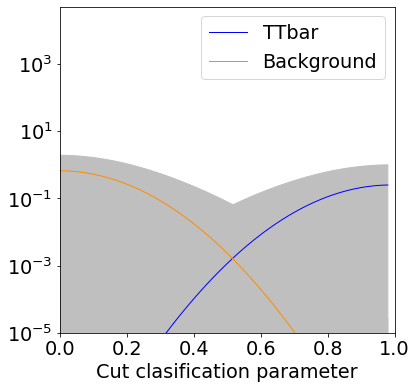

In [56]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,6))# 6,6
plt.figure(1) 
plt.style.use('seaborn-deep')
plt.plot(g[0:nbins], counts_signal, color='blue',lw=1, label='TTbar')
plt.fill_between(g[0:nbins], counts_signal-(variance_signal)**0.5, counts_signal+(variance_signal)**0.5,color='0.75')
plt.plot(g[0:nbins], counts_back, color='darkorange',lw=1, label='Background')
plt.fill_between(g[0:nbins], counts_back-(variance_back)**0.5, counts_back+(variance_back)**0.5,color='0.75')
plt.xlim([0.0, 1.0])
plt.ylim([0.00001, 50000])
plt.xlabel('Cut clasification parameter')
plt.yscale("log")
plt.legend()

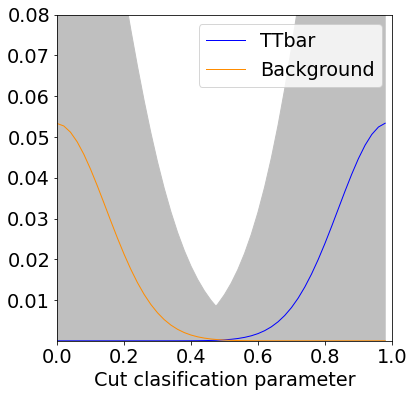

In [57]:
# Normalized

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,6))# 6,6
plt.figure(1) 
plt.style.use('seaborn-deep')
plt.plot(g[0:nbins], counts_signal/sum(w1), color='blue',lw=1, label='TTbar')
plt.fill_between(g[0:nbins], (counts_signal-(variance_signal)**0.5)/sum(w1), (counts_signal+(variance_signal)**0.5)/sum(w1),color='0.75')
plt.plot(g[0:nbins], counts_back/sum(w0), color='darkorange',lw=1, label='Background')
plt.fill_between(g[0:nbins], (counts_back-(variance_back)**0.5)/sum(w0), (counts_back+(variance_back)**0.5)/sum(w0),color='0.75')
plt.xlim([0.0, 1.0])
plt.ylim([0.00001, 0.08])
plt.xlabel('Cut clasification parameter')
#plt.yscale("log")
plt.legend()

Text(0.5, 1.0, 'Count histogram')

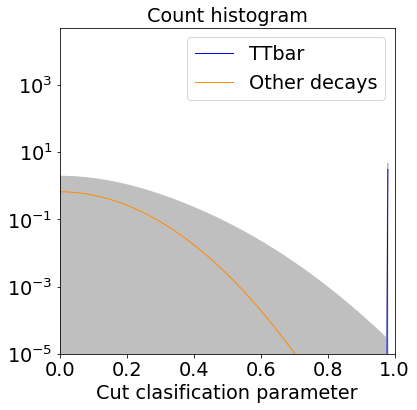

In [58]:
## Without tau

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,6))# 6,6
plt.figure(1) 
plt.style.use('seaborn-deep')
plt.plot(g[0:nbins], counts_signal_nt, color='blue',lw=1, label='TTbar')
plt.fill_between(g[0:nbins], counts_signal_nt-(variance_signal_nt)**0.5, counts_signal_nt+(variance_signal_nt)**0.5,color='0.75')
plt.plot(g[0:nbins], counts_back, color='darkorange',lw=1, label='Other decays')
plt.fill_between(g[0:nbins], counts_back-(variance_back)**0.5, counts_back+(variance_back)**0.5,color='0.75')
plt.xlim([0.0, 1.0])
plt.ylim([0.00001, 50000])
plt.xlabel('Cut clasification parameter')
plt.yscale("log")
plt.legend()
plt.title('Count histogram')

In [0]:
## TPR and FPR

# We set the histogram bins separation in 150.

g = linspace(0,1,nbins+1)

# We now btain the matrix p_{ij} that gathers the probability of prediction 
sP_signal = (len(m_signal),nbins)
sP_back = (len(m_back),nbins)

# P matrix that shows probability of event i counting for place j

P_tpr = np.zeros(sP_signal)
P_fpr = np.zeros(sP_back)

# Without tau

P_tpr_nt = np.zeros(sP_signal)
P_fpr_nt = np.zeros(sP_back)

from scipy.stats import norm

for i in range(len(m_signal)):
  for j in range(nbins):
    P_tpr[i,j] = (1-norm.cdf(g[j],loc=m_signal[i],scale=sqrt(v_signal[i])))
    P_tpr_nt[i,j] = (1-norm.cdf(g[j],loc=m_signal[i],scale=sqrt(v_signal_nt[i])))

for i in range(len(m_back)):
  for j in range(nbins):
    P_fpr[i,j] = (1-norm.cdf(g[j],loc=m_back[i],scale=sqrt(v_back[i])))
    P_fpr_nt[i,j] = (1-norm.cdf(g[j],loc=m_back[i],scale=sqrt(v_back_nt[i])))

Area under the roc curve is 0.999998649609174
Superior area under the roc curve is 1.0001091462557343
Inferior area under the roc curve is 0.9998881529626131


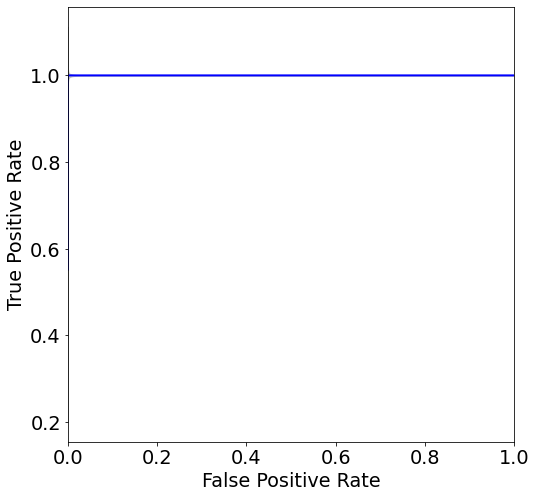

In [60]:
aux_tpr=np.multiply(P_tpr,Weights1)
aux_fpr=np.multiply(P_fpr,Weights0)

counts_tpr= (np.sum(aux_tpr,axis=0))/sum(w1)
counts_fpr= (np.sum(aux_fpr,axis=0))/sum(w0)
counts_fpr[0] = 1

contrary = 1-P_tpr
contrary2 = 1-P_fpr

variance = np.multiply(P_tpr,contrary)
variance2 = np.multiply(P_fpr,contrary2)
variance = np.multiply(variance,Weights1**2)
variance2 = np.multiply(variance2,Weights0**2)

variance_tpr = (np.sum(variance,axis=0))/(sum(w1)**2)
variance_fpr = (np.sum(variance2,axis=0))/(sum(w0)**2)


fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))# 6,6
plt.figure(1)
plt.style.use('seaborn-deep')
plt.plot(counts_fpr, counts_tpr, color='blue',lw=2)
plt.fill_between(counts_fpr, counts_tpr-(variance_tpr)**0.5, counts_tpr+(variance_tpr)**0.5,color='0.75')
plt.xlim([0.0, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

## Area under the curve

Area_auc = np.trapz(counts_tpr, x = counts_fpr)
Area_auc_sup = np.trapz(counts_tpr+(variance_tpr)**0.5, x = counts_fpr)
Area_auc_inf = np.trapz(counts_tpr-(variance_tpr)**0.5, x = counts_fpr)

print('Area under the roc curve is',-Area_auc)
print('Superior area under the roc curve is',-Area_auc_sup)
print('Inferior area under the roc curve is',-Area_auc_inf)

Text(0.5, 0, 'False Positive Rate')

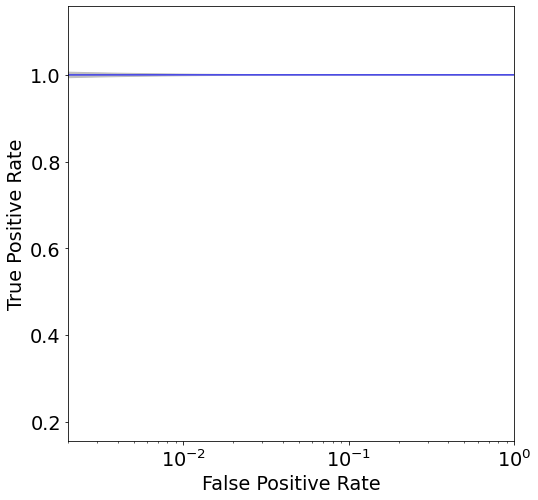

In [61]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))# 6,6
plt.figure(1)
plt.style.use('seaborn-deep')
plt.plot(counts_fpr, counts_tpr, color='blue',lw=1, label='ROC curve')
plt.fill_between(counts_fpr, counts_tpr-(variance_tpr)**0.5, counts_tpr+(variance_tpr)**0.5,color='0.75')
plt.xscale('log', basex = 10)
plt.xlim([0.002, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [62]:
## Operation points

#Punto 99%
operation_point99 =g[0:nbins][counts_fpr>0.01][-1]
tpr99 = counts_tpr[counts_fpr>0.01][-1]

#Punto 99.9%
operation_point999 =g[0:nbins][counts_fpr>0.001][-1]
tpr999 = counts_tpr[counts_fpr>0.001][-1]

print('Operation point at 99%',operation_point99)
print('Operation point at 99.9%',operation_point999)
print('True positive rate at 99%',tpr99)
print('True positive rate at 99.9%',tpr999)


Operation point at 99% 0.34
Operation point at 99.9% 0.46
True positive rate at 99% 0.9999951503213496
True positive rate at 99.9% 0.9998520232664122


In [63]:
# Variance 

#Punto 99%
operation_point99_sup =g[0:nbins][(counts_fpr+(variance_fpr)**0.5)>0.01][-1]

operation_point99_inf =g[0:nbins][(counts_fpr-(variance_fpr)**0.5)>0.01][-1]


#Punto 99.9%
operation_point999_sup =g[0:nbins][(counts_fpr+(variance_fpr)**0.5)>0.001][-1]

operation_point999_inf =g[0:nbins][(counts_fpr-(variance_fpr)**0.5)>0.001][-1]


print('Operation point at 99%',operation_point99)
print('Interval inf',operation_point99_inf)
print('Interval sup',operation_point99_sup)
print('Operation point at 99.9%',operation_point999)
print('Interval inf',operation_point999_inf)
print('Interval sup',operation_point999_sup)


Operation point at 99% 0.34
Interval inf 0.14
Interval sup 0.5
Operation point at 99.9% 0.46
Interval inf 0.14
Interval sup 0.66


In [64]:
tpr99_sup = (counts_tpr+(variance_tpr)**0.5)[(counts_fpr)>0.01][-1]
tpr99_inf = (counts_tpr-(variance_tpr)**0.5)[(counts_fpr)>0.01][-1]
tpr999_sup = (counts_tpr+(variance_tpr)**0.5)[(counts_fpr)>0.001][-1]
tpr999_inf = (counts_tpr-(variance_tpr)**0.5)[(counts_fpr)>0.001][-1]

print('True positive rate at 99%',tpr99)

print('Interval inf',tpr99_inf)
print('Interval sup',tpr99_sup)


print('True positive rate at 99.9%',tpr999)
print('Interval inf',tpr999_inf)
print('Interval sup',tpr999_sup)

True positive rate at 99% 0.9999951503213496
Interval inf 0.9984379645374479
Interval sup 1.0015523361052512
True positive rate at 99.9% 0.9998520232664122
Interval inf 0.9912510106378285
Interval sup 1.008453035894996


(0.0, 1.0)

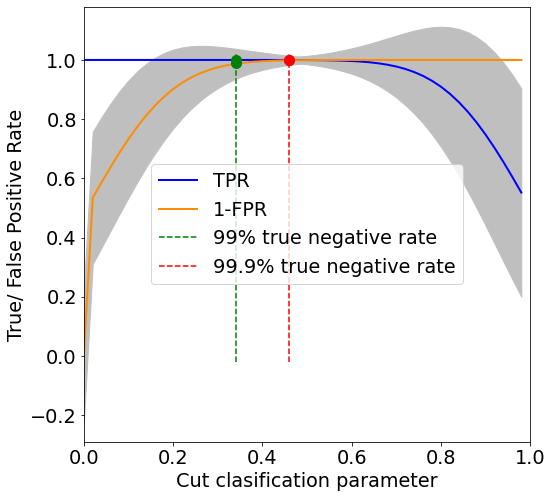

In [65]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))# 6,6
plt.figure(1) 
plt.style.use('seaborn-deep')
plt.plot(g[0:nbins], counts_tpr, color='blue',lw=2, label='TPR')
plt.fill_between(g[0:nbins], counts_tpr-(variance_tpr)**0.5, counts_tpr+(variance_tpr)**0.5,color='0.75')
plt.plot(g[0:nbins], 1-counts_fpr, color='darkorange',lw=2, label='1-FPR')
plt.fill_between(g[0:nbins], 1-counts_fpr-(variance_fpr)**0.5, 1-counts_fpr+(variance_fpr)**0.5,color='0.75')
plt.plot([operation_point99,operation_point99], [-0.02,1.02],'g--' ,color='green',lw=1.5,label ='99% true negative rate')
plt.plot([operation_point999,operation_point999], [-0.02,1.02],'r--', color='red',lw=1.5,label ='99.9% true negative rate')
plt.plot(operation_point99,0.99,'go',ms=10)
plt.plot(operation_point999,0.999,'ro',ms=10)
plt.plot(operation_point99,tpr99,'go',ms=10)
plt.plot(operation_point999,tpr999,'ro',ms=10)
plt.ylabel('True/ False Positive Rate')
plt.xlabel('Cut clasification parameter')
plt.legend()
plt.xlim([0.0, 1.0])

Without the tau


Text(0.5, 1.0, 'Test performance')

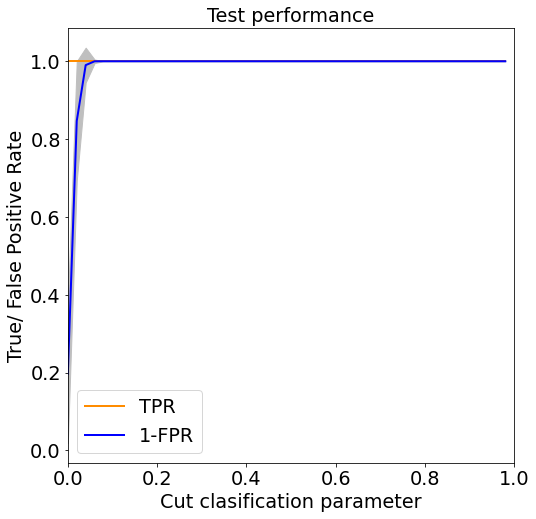

In [66]:
# Without the tau
aux_tpr_nt=np.multiply(P_tpr_nt,Weights1)
aux_fpr_nt=np.multiply(P_fpr_nt,Weights0)

counts_tpr_nt= (np.sum(aux_tpr_nt,axis=0))/sum(w1)
counts_fpr_nt= (np.sum(aux_fpr_nt,axis=0))/sum(w0)
counts_fpr[0] = 1

contrary = 1-P_tpr_nt
contrary2 = 1-P_fpr_nt

variance = np.multiply(P_tpr_nt,contrary)
variance2 = np.multiply(P_fpr_nt,contrary2)
variance = np.multiply(variance,Weights1**2)
variance2 = np.multiply(variance2,Weights0**2)

variance_tpr_nt = (np.sum(variance,axis=0))/(sum(w1)**2)
variance_fpr_nt = (np.sum(variance2,axis=0))/(sum(w0)**2)


fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))# 6,6
plt.figure(1) 
plt.style.use('seaborn-deep')
plt.plot(g[0:nbins], counts_tpr_nt, color='darkorange',lw=2, label='TPR')
plt.fill_between(g[0:nbins], counts_tpr_nt-(variance_tpr_nt)**0.5, counts_tpr_nt+(variance_tpr_nt)**0.5,color='0.75')
plt.plot(g[0:nbins], 1-counts_fpr_nt, color='blue',lw=2, label='1-FPR')
plt.fill_between(g[0:nbins], 1-counts_fpr_nt-(variance_fpr_nt)**0.5, 1-counts_fpr_nt+(variance_fpr_nt)**0.5,color='0.75')
plt.ylabel('True/ False Positive Rate')
plt.xlabel('Cut clasification parameter')
plt.legend()
plt.xlim([0.0, 1.0])
plt.title('Test performance')


(0.0, 1.0)

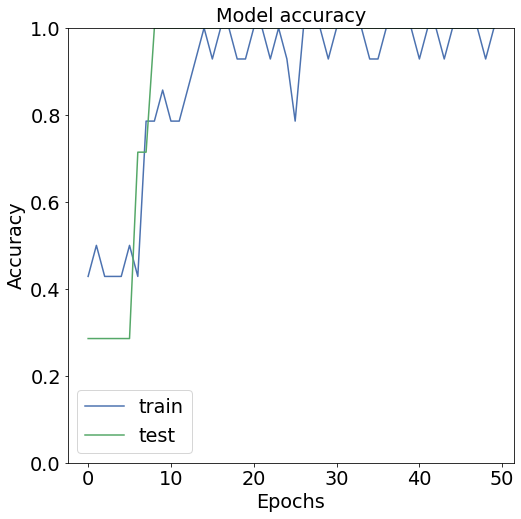

In [69]:
# summarize history for acc
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))# 6,6
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#ax.set_yscale("log")
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.ylim([0, 1.0])

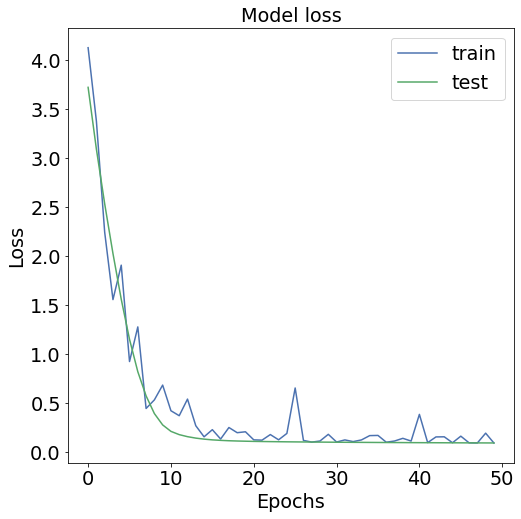

In [68]:
# summarize history for loss
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))# 6,6
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])